In [1]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt

from jax import grad,jit, jacfwd
from matplotlib import pyplot as plt
import jax.numpy as jnp

from functools import partial
%load_ext autoreload
%autoreload 2

In [50]:
from jax import jit, jacfwd
import jax.numpy as jnp

def sep_func(ps):
	CoM = jnp.mean(ps,axis=0)
	A = ps-CoM
	return jnp.linalg.det(A.T.dot(A))

def mutual_separation_path_planning(R,ps,n_p,n_steps,max_linear_speed,dt):
	step_size = max_linear_speed*dt
	ps=ps.reshape(-1,2)

	f_dLdp = jit(jacfwd(sep_func))
	p_trajs=[]
	n_timesteps = 20
	reached=False
	for i in range(n_timesteps):
			# Calculate the gradient

			CoM= np.mean(ps,axis = 0)
			grad=f_dLdp(ps)
			if np.any(np.isnan(grad)): # This is a hack that gets rid of degenerate gradient with random directions
				grad = np.random.random(ps.shape)
			grad=grad.reshape(-1,2)
			grad_sizes=np.linalg.norm(grad,axis=1)
			grad_sizes[grad_sizes==0]=1 # Handle the case where the partial derivative is zero.

			update_steps=(grad.T/np.max(grad_sizes) * step_size).T # Calculate the update steps to be applied to ps

			candid_ps=np.array(ps+update_steps) # Calculate the direct update 

			# Prevent the ps from getting too far away by doing projection
			for j in range(len(candid_ps)):
				candid_ps[j,:] = CircleInterior(CoM,R).project_point(candid_ps[j,:])
			
			p_trajs.append(candid_ps)
			
			if np.max(np.linalg.norm(ps-candid_ps,axis=1))<0.1 and i == 0:
				reached = True
				break
			ps=candid_ps # Update ps.
			
	p_trajs = np.array(p_trajs)
	return p_trajs,reached

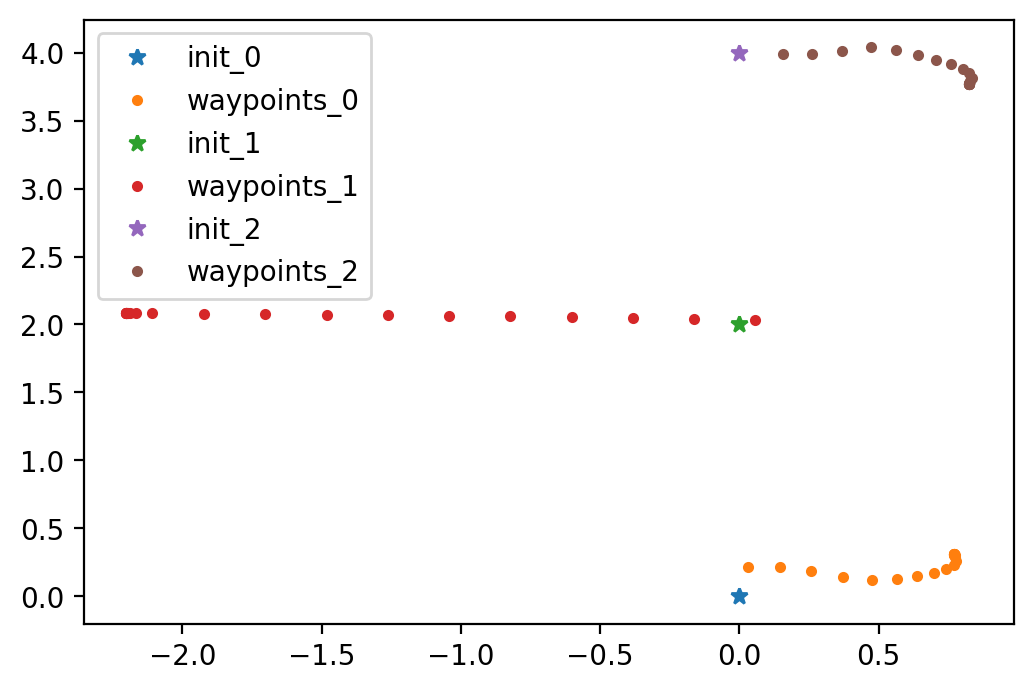

In [51]:
from regions import CircleInterior
R=2
ps=np.array([[0.0,0.],[0.,2.],[0.,4.]])
n_p = len(ps)
max_linear_speed=0.22
dt = 1
n_steps = 300
p_trajs=[]

p_trajs,reached = mutual_separation_path_planning(R,ps,n_p,n_steps,max_linear_speed,dt)  
fig = plt.figure(dpi=200)
for i in range(n_p):
    plt.plot(ps[i,0],ps[i,1],'*',label = 'init_{}'.format(i))
    plt.plot(p_trajs[:,i,0],p_trajs[:,i,1],'.',label= 'waypoints_{}'.format(i))
plt.legend()
plt.show()